# RRSG With RIESLING

This Notebook shows how RIESLING can be used to reconstruct the ISMRM Reproducible Research Study Group cg-SENSE Challenge dataset:

O. Maier et al., ‘CG‐SENSE revisited: Results from the first ISMRM reproducibility challenge’, Magnetic Resonance in Medicine, Nov. 2020, doi: 10.1002/mrm.28569.


In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import requests

import h5py
import matplotlib.pyplot as plt
import numpy as np
import riesling as rl
from riesling_rrsg import convert_rrsg

First, we download the RRSG data from Zenodo

In [2]:
zenodo_files=['rawdata_brain_radial_96proj_12ch.h5', 'rawdata_spiral_ETH.h5']
data_dir = 'rrsg'

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for zf in zenodo_files:
    if not os.path.isfile(f'{data_dir}/{zf}'):
        print(f'Downloading {zf}')
        res = requests.get(f'https://zenodo.org/record/3975887/files/{zf}')
        with open(f'{data_dir}/{zf}', 'wb') as h5f:
            h5f.write(res.content)
    else:
        print(f'Already downloaded {zf}')

Already downloaded rawdata_brain_radial_96proj_12ch.h5
Already downloaded rawdata_spiral_ETH.h5


Then we convert from the RRSG format to the RIESLING format. A utility function is provided in `riesling_rrsg.py` for this. We need to supply the desired matrix and voxel sizes.

In [3]:
matrix_sizes = [[256, 256, 1], [220, 220, 1]]
voxel_sizes = [[0.78, 0.78, 2], [1, 1, 2]]
radial_stem = 'rrsg-radial'
spiral_stem = 'rrsg-spiral'
rpre=f'{data_dir}/{radial_stem}'
spre=f'{data_dir}/{spiral_stem}'
riesling_files = [f'{radial_stem}.h5', f'{spiral_stem}.h5']
for (inname, mtx, vox, outname) in zip(zenodo_files, matrix_sizes, voxel_sizes, riesling_files):
    convert_rrsg(input_fname=f'{data_dir}/{inname}',
                 output_fname=f'{data_dir}/{outname}',
                 matrix=mtx, voxel_size=vox)

H5 file saved to rrsg/rrsg-radial.h5
H5 file saved to rrsg/rrsg-spiral.h5


## Radial Dataset

First, we plot the trajectory to confirm this is a 2D radial dataset.

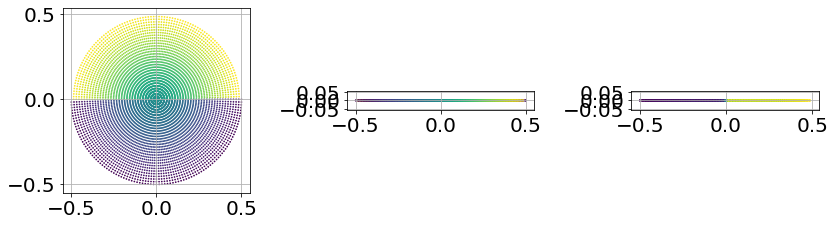

In [4]:
rl.plots.traj2d(f'{rpre}.h5', sl_read=slice(0,-1,8))

Now we self-calibrate the SENSE maps and pre-calculate SDC

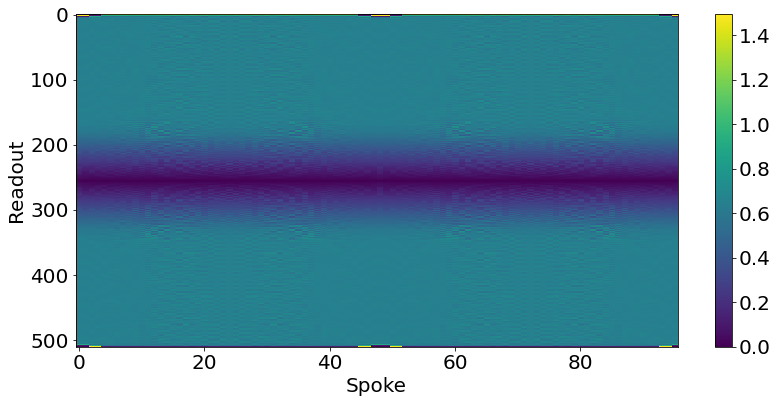

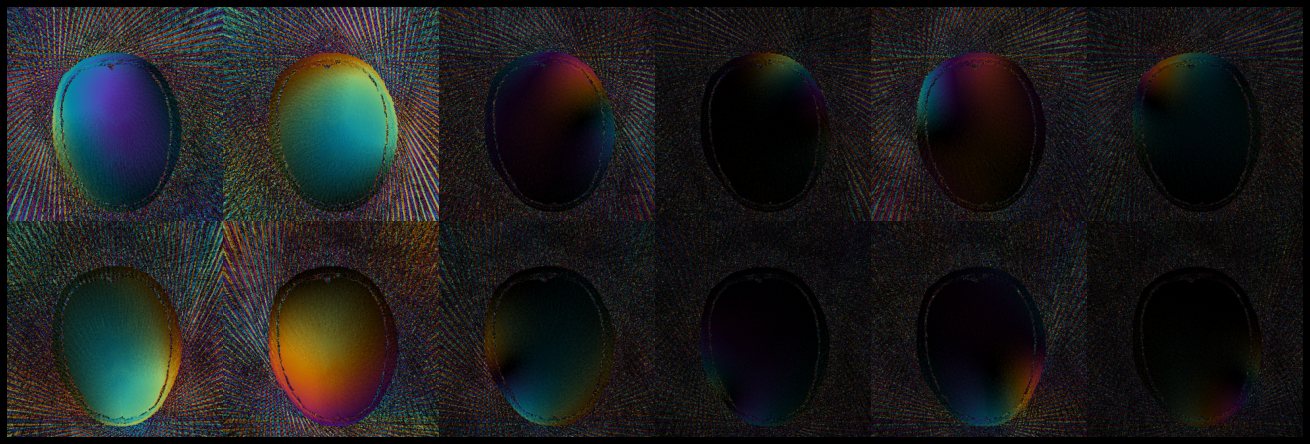

In [5]:
!riesling sdc --os=2.5 {rpre}.h5 --sdc=pipe --out {rpre}
!riesling sense-calib --os=2.5 {rpre}.h5 --sdc={rpre}-sdc.h5 --out {rpre}
display(rl.plots.sdc(f'{rpre}-sdc.h5'))
display(rl.images.sense(f'{rpre}-sense.h5', nrows=2))

Then we reconstruct the image with the different methods available in `riesling` and compare the outcomes. Note that because we are processing the data in a subdirectory, it is necessary to use the `--out` argument, otherwise the data would be written in the parent directory. We specify the Field-of-View with `--fov` as directed in the paper.

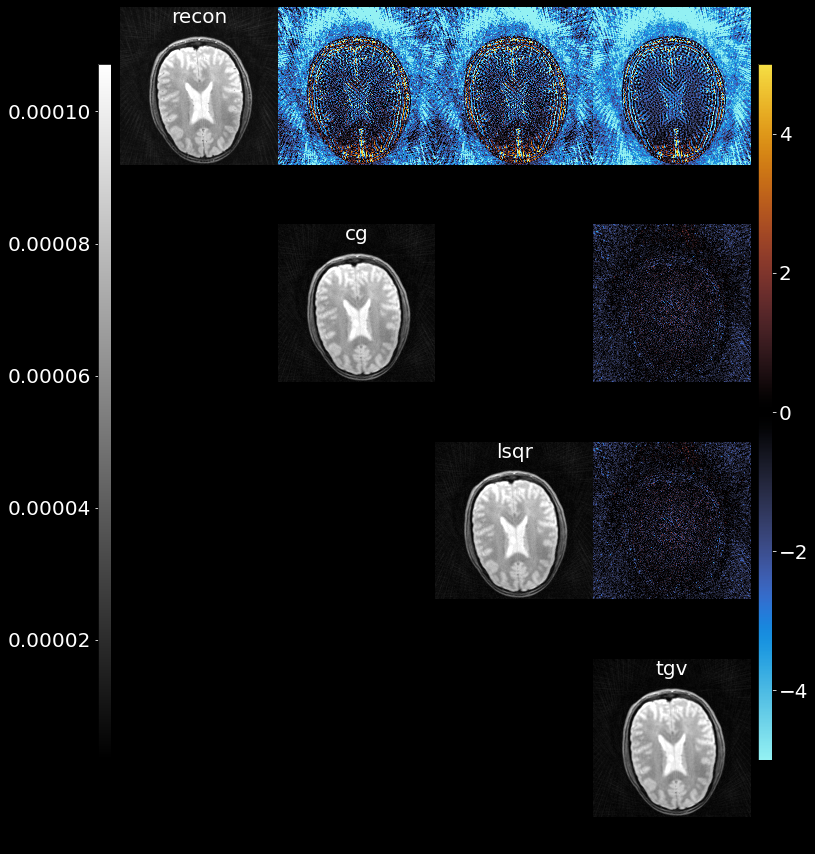

In [6]:
fov = 234
args = f'--fov={fov} --kernel=KB3 --os=2.5 --out {rpre} {rpre}.h5  --sdc={rpre}-sdc.h5 --sense={rpre}-sense.h5'
!riesling recon {args}
!riesling cg {args} --cg_its=32 --cg_thresh=1e-16
!riesling lsqr {args} --lsq_its=32 --lsq_thresh=1e-16
!riesling tgv {args} --max_its=32 --thresh=1e-16
rl.images.diffN([f'{rpre}-recon.h5',f'{rpre}-cg.h5',f'{rpre}-lsqr.h5',f'{rpre}-tgv.h5'],
    titles=['recon','cg','lsqr','tgv'], difflim=(-5,5))

## Spiral Dataset

Now we repeat the above for the spiral dataset

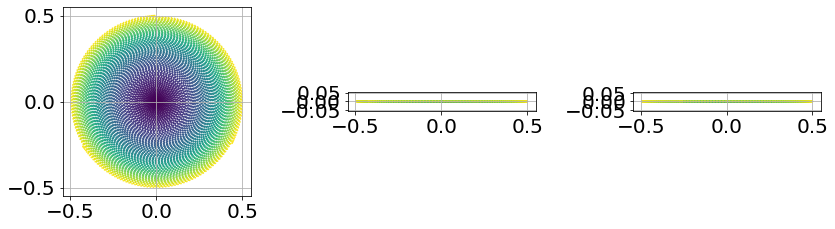

In [7]:
rl.plots.traj2d(f'{spre}.h5', sl_read=slice(None,None,8))

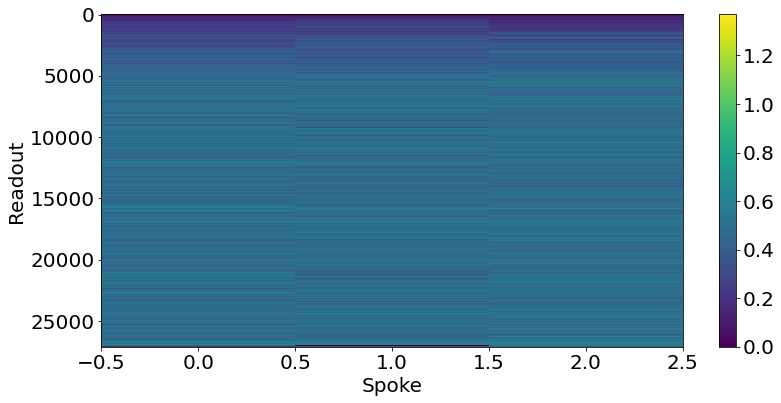

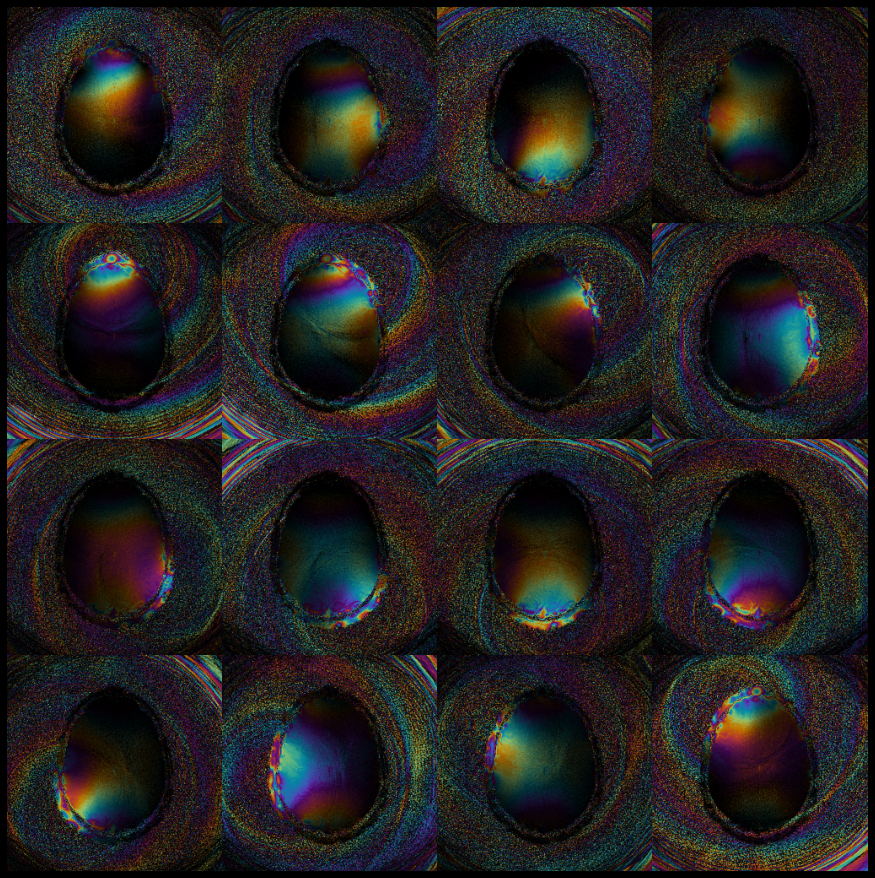

In [8]:
!riesling sdc --os=2.5 {spre}.h5 --sdc=pipe --out {spre}
!riesling sense-calib --os=2.5 {spre}.h5 --sdc={spre}-sdc.h5 --out {spre}
display(rl.plots.sdc(f'{spre}-sdc.h5'))
display(rl.images.sense(f'{spre}-sense.h5', nrows=4))

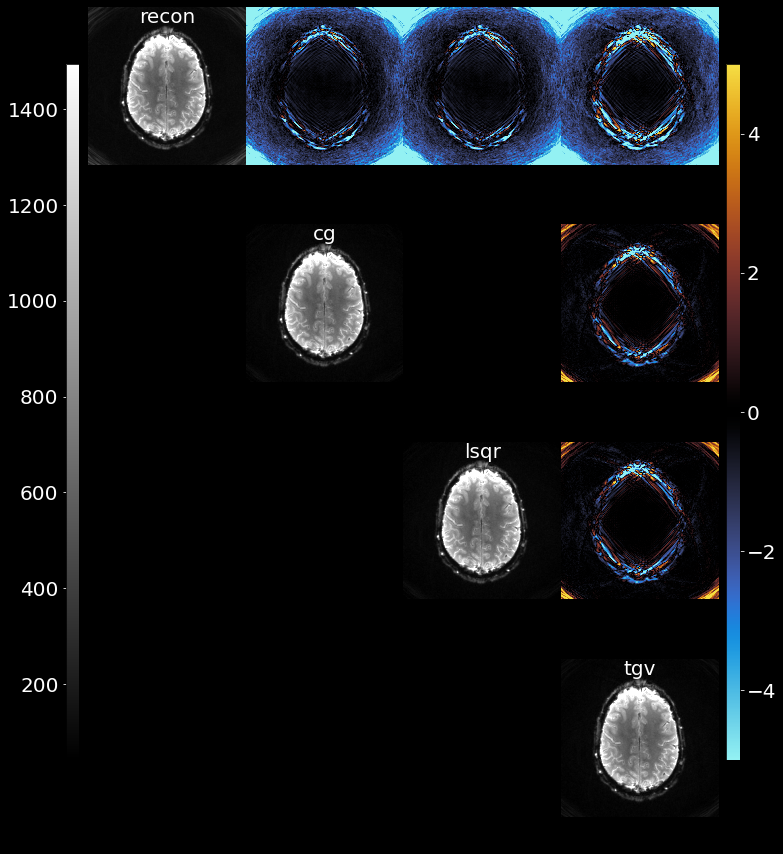

In [9]:
fov=240
args=f'--fov={fov} {spre}.h5 --out {spre} --sense={spre}-sense.h5 --sdc={spre}-sdc.h5'
!riesling recon {args}
!riesling cg {args}
!riesling lsqr {args}
!riesling tgv {args}
rl.images.diffN([f'{spre}-recon.h5',f'{spre}-cg.h5',f'{spre}-lsqr.h5',f'{spre}-tgv.h5'],
    titles=['recon','cg','lsqr','tgv'], difflim=(-5,5))